In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc,precision_recall_curve, average_precision_score
from sklearn.preprocessing import OneHotEncoder,label_binarize , LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils import resample

In [3]:
df_info = pd.read_csv('/content/drive/MyDrive/EMR/Patient_information_cleaned.csv')
df_complications = pd.read_csv('/content/drive/MyDrive/EMR/Processed_patient_post_op_complications.csv')


In [4]:
df_info.columns

Index(['LOG_ID', 'MRN', 'DISCH_DISP_C', 'DISCH_DISP', 'LOS', 'ICU_ADMIN_FLAG',
       'SURGERY_DATE', 'BIRTH_DATE', 'WEIGHT', 'SEX', 'PRIMARY_ANES_TYPE_NM',
       'ASA_RATING_C', 'ASA_RATING', 'PATIENT_CLASS_GROUP', 'PATIENT_CLASS_NM',
       'PRIMARY_PROCEDURE_NM', 'PATIENT_CLASS_NM_ENCODED',
       'PATIENT_CLASS_GROUP_ENCODED', 'OR_LOS_HOURS', 'AN_LOS_HOURS',
       'HEIGHT_METRES', 'PRIMARY_PROCEDURE_NM_ENCODED',
       'PRIMARY_ANES_TYPE_NM_ENCODED'],
      dtype='object')

In [5]:
df_complications.columns

Index(['LOG_ID', 'MRN', 'SMRTDTA_ELEM_VALUE', 'CONTEXT_NAME_encoded',
       'Post_OP_type_AN  ADMINISTRATIVE', 'Post_OP_type_AN  AIRWAY',
       'Post_OP_type_AN  CARDIOVASCULAR', 'Post_OP_type_AN  CHRONIC PAIN',
       'Post_OP_type_AN  INJURY/INFECTION', 'Post_OP_type_AN  MEDICATION',
       'Post_OP_type_AN  METABOLIC', 'Post_OP_type_AN  NEUROLOGICAL',
       'Post_OP_type_AN AQI ', 'Post_OP_type_ANE  OTHER',
       'Post_OP_type_ANE  REGIONAL', 'Post_OP_type_ANE  RESPIRATORY',
       'SMRTDTA_embeddings'],
      dtype='object')

In [6]:
df_info['Unique_Key'] = df_info['MRN'].astype(str) + ':_:' + df_info['LOG_ID'].astype(str).str.strip()
df_complications['Unique_Key'] = df_complications['MRN'].astype(str) + ':_:' + df_complications['LOG_ID'].astype(str).str.strip()

In [7]:
common_keys = set(df_info['Unique_Key']).intersection(set(df_complications['Unique_Key']))


In [8]:
len(common_keys)

59441

In [9]:
len(df_info['LOG_ID']) , len(df_info['LOG_ID'].unique())

(64124, 62796)

In [10]:
len(set(df_complications['LOG_ID']+" "+df_complications['MRN']).intersection(set(df_info['LOG_ID']+" "+df_info['MRN'])))

59441

In [11]:
len(df_complications['LOG_ID']) , len(df_complications['LOG_ID'].unique())


(203945, 64214)

In [12]:
df1_filtered = df_info[df_info['Unique_Key'].isin(common_keys)]
df2_filtered = df_complications[df_complications['Unique_Key'].isin(common_keys)]

merged_df = pd.merge(df1_filtered, df2_filtered, on='Unique_Key', suffixes=('_info', '_complications'))


In [13]:
df1_filtered.head()

,LOG_ID,MRN,DISCH_DISP_C,DISCH_DISP,LOS,ICU_ADMIN_FLAG,SURGERY_DATE,BIRTH_DATE,WEIGHT,SEX,...,PATIENT_CLASS_NM,PRIMARY_PROCEDURE_NM,PATIENT_CLASS_NM_ENCODED,PATIENT_CLASS_GROUP_ENCODED,OR_LOS_HOURS,AN_LOS_HOURS,HEIGHT_METRES,PRIMARY_PROCEDURE_NM_ENCODED,PRIMARY_ANES_TYPE_NM_ENCODED,Unique_Key
0,cd1636c6279d73a0,2e92522a5f2a2a22,15.0,Home Routine,1.0,0,2018-12-20,47,2832.47,0,...,Hospital Outpatient Surgery,"INSERTION, PUBOVAGINAL SLING, WITH CYSTOSCOPY",1,1,4.97,4.97,1.68,"[101, 23851, 1010, 9047, 7103, 24965, 27076, 1...",2,2e92522a5f2a2a22:_:cd1636c6279d73a0
1,fc53c06ee2cfe438,b7a91e623d957d8f,16.0,Hospice Facility,21.0,1,2019-09-27,81,2515.01,1,...,Hospital Outpatient Surgery,GI EGD DILATION,1,1,1.58,1.58,1.68,"[101, 21025, 1041, 2290, 2094, 29454, 3370, 102]",2,b7a91e623d957d8f:_:fc53c06ee2cfe438
2,2f0090c47da34608,b68d6c7198f30f73,15.0,Home Routine,3.0,1,2019-04-08,49,1964.74,0,...,Hospital Inpatient Surgery,CRANIECTOMY,0,0,4.08,4.08,1.68,"[101, 13675, 7088, 22471, 16940, 102]",2,b68d6c7198f30f73:_:2f0090c47da34608
4,82f89e10f2855420,c2756216cc89b795,15.0,Home Routine,1.0,0,2019-04-19,44,1880.08,0,...,Hospital Outpatient Surgery,"REVISION, RECONSTRUCTION, BREAST",1,1,6.63,6.63,1.68,"[101, 13921, 1010, 8735, 1010, 7388, 102]",2,c2756216cc89b795:_:82f89e10f2855420
5,8778901eeb9b6166,2e34dcb0791b8c0d,15.0,Home Routine,1.0,0,2020-03-17,59,2640.00,0,...,Hospital Outpatient Surgery,EGD (ESOPHAGOGASTRODUODENOSCOPY),1,1,2.02,2.02,1.68,"[101, 1041, 2290, 2094, 1006, 9686, 7361, 3270...",2,2e34dcb0791b8c0d:_:8778901eeb9b6166


In [14]:
df2_filtered.head()

,LOG_ID,MRN,SMRTDTA_ELEM_VALUE,CONTEXT_NAME_encoded,Post_OP_type_AN ADMINISTRATIVE,Post_OP_type_AN AIRWAY,Post_OP_type_AN CARDIOVASCULAR,Post_OP_type_AN CHRONIC PAIN,Post_OP_type_AN INJURY/INFECTION,Post_OP_type_AN MEDICATION,Post_OP_type_AN METABOLIC,Post_OP_type_AN NEUROLOGICAL,Post_OP_type_AN AQI,Post_OP_type_ANE OTHER,Post_OP_type_ANE REGIONAL,Post_OP_type_ANE RESPIRATORY,SMRTDTA_embeddings,Unique_Key
0,b00c588406aae5cc,1a42f0bed60c5598,missing,0,0,0,0,0,0,0,0,0,1,0,0,0,[],1a42f0bed60c5598:_:b00c588406aae5cc
1,a16571d21874c0a7,596a6dc60f54a0bb,missing,1,0,0,0,0,0,0,0,0,1,0,0,0,[],596a6dc60f54a0bb:_:a16571d21874c0a7
2,a16571d21874c0a7,596a6dc60f54a0bb,missing,1,0,0,0,0,0,0,0,0,1,0,0,0,[],596a6dc60f54a0bb:_:a16571d21874c0a7
4,2ae43a4a39735956,59c5483e0654e105,other,0,0,0,0,0,0,0,0,0,1,0,0,0,[-1.00854790e+00 5.63978493e-01 5.91462553e-...,59c5483e0654e105:_:2ae43a4a39735956
5,c7680ab4d890c0fe,2871383f18be5007,missing,0,0,0,0,0,0,0,0,0,1,0,0,0,[],2871383f18be5007:_:c7680ab4d890c0fe


In [15]:
merged_df['Unique_Key'].value_counts()

,count
Unique_Key,
1bb09d5761661c7d:_:cb6698ea372d68fe,76
1bb09d5761661c7d:_:d900502f8b9aec4d,76
1bb09d5761661c7d:_:89112300bdcbe94d,76
1bb09d5761661c7d:_:1ffac35516c3bd3c,76
1bb09d5761661c7d:_:b66a8038ae99839f,76
...,...
df48e84fbaad0b94:_:27cef21e0290e989,1
70b3be27e1c4017c:_:d51ea078a85cdb55,1
a1c92e0b50f01f94:_:8085a7bdb51786b8,1


In [16]:
merged_df[merged_df['Unique_Key']=='1bb09d5761661c7d:_:cb6698ea372d68fe']

,LOG_ID_info,MRN_info,DISCH_DISP_C,DISCH_DISP,LOS,ICU_ADMIN_FLAG,SURGERY_DATE,BIRTH_DATE,WEIGHT,SEX,...,Post_OP_type_AN CHRONIC PAIN,Post_OP_type_AN INJURY/INFECTION,Post_OP_type_AN MEDICATION,Post_OP_type_AN METABOLIC,Post_OP_type_AN NEUROLOGICAL,Post_OP_type_AN AQI,Post_OP_type_ANE OTHER,Post_OP_type_ANE REGIONAL,Post_OP_type_ANE RESPIRATORY,SMRTDTA_embeddings
61006,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
61007,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
61008,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
61009,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
61010,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82422,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
82423,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
82424,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
82425,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]


In [17]:
df_unique = merged_df.drop_duplicates(subset=['Unique_Key'], keep='first')


In [18]:
df_unique['Post_OP_type_AN  CHRONIC PAIN'].unique()


array([0])

In [19]:
df_unique['Unique_Key'].value_counts()


,count
Unique_Key,
2e92522a5f2a2a22:_:cd1636c6279d73a0,1
04ef0014e5b3d035:_:105639f3d420ad60,1
9bfae6065a3b7106:_:bcfb45229acc96fe,1
3c4bb70d45ca86f3:_:2a5ebf37ca82abcb,1
7f2b5a462168e9ba:_:a9b00991dd7e4993,1
...,...
14117f6d53a3ac68:_:76b5c3c49d32c3ec,1
2bb4d67d68caf0d6:_:511efb07b1ea8694,1
1d2cee1262f80f34:_:972e54c782c2faae,1


In [20]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59441 entries, 0 to 186072
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   LOG_ID_info                        59441 non-null  object 
 1   MRN_info                           59441 non-null  object 
 2   DISCH_DISP_C                       59439 non-null  float64
 3   DISCH_DISP                         59439 non-null  object 
 4   LOS                                59441 non-null  float64
 5   ICU_ADMIN_FLAG                     59441 non-null  int64  
 6   SURGERY_DATE                       59441 non-null  object 
 7   BIRTH_DATE                         59441 non-null  int64  
 8   WEIGHT                             59441 non-null  float64
 9   SEX                                59441 non-null  int64  
 10  PRIMARY_ANES_TYPE_NM               59441 non-null  object 
 11  ASA_RATING_C                       53555 non-null  float64

In [21]:
df_unique.columns

Index(['LOG_ID_info', 'MRN_info', 'DISCH_DISP_C', 'DISCH_DISP', 'LOS',
       'ICU_ADMIN_FLAG', 'SURGERY_DATE', 'BIRTH_DATE', 'WEIGHT', 'SEX',
       'PRIMARY_ANES_TYPE_NM', 'ASA_RATING_C', 'ASA_RATING',
       'PATIENT_CLASS_GROUP', 'PATIENT_CLASS_NM', 'PRIMARY_PROCEDURE_NM',
       'PATIENT_CLASS_NM_ENCODED', 'PATIENT_CLASS_GROUP_ENCODED',
       'OR_LOS_HOURS', 'AN_LOS_HOURS', 'HEIGHT_METRES',
       'PRIMARY_PROCEDURE_NM_ENCODED', 'PRIMARY_ANES_TYPE_NM_ENCODED',
       'Unique_Key', 'LOG_ID_complications', 'MRN_complications',
       'SMRTDTA_ELEM_VALUE', 'CONTEXT_NAME_encoded',
       'Post_OP_type_AN  ADMINISTRATIVE', 'Post_OP_type_AN  AIRWAY',
       'Post_OP_type_AN  CARDIOVASCULAR', 'Post_OP_type_AN  CHRONIC PAIN',
       'Post_OP_type_AN  INJURY/INFECTION', 'Post_OP_type_AN  MEDICATION',
       'Post_OP_type_AN  METABOLIC', 'Post_OP_type_AN  NEUROLOGICAL',
       'Post_OP_type_AN AQI ', 'Post_OP_type_ANE  OTHER',
       'Post_OP_type_ANE  REGIONAL', 'Post_OP_type_ANE  RESPIRA

In [22]:
columns_to_remove = ['LOG_ID_info',
'MRN_info',
'DISCH_DISP_C',
'DISCH_DISP',
'SURGERY_DATE',
'BIRTH_DATE',
'ASA_RATING',
'PATIENT_CLASS_GROUP',
'PATIENT_CLASS_NM',
'PATIENT_CLASS_GROUP_ENCODED',
'PATIENT_CLASS_NM_ENCODED',
'PRIMARY_ANES_TYPE_NM',
'LOG_ID_complications',
'MRN_complications',
'CONTEXT_NAME_encoded',
'PRIMARY_PROCEDURE_NM_ENCODED','SMRTDTA_embeddings']

df_final = df_unique.copy()

df_final = df_final.drop(columns=columns_to_remove)

In [23]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59441 entries, 0 to 186072
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   LOS                                59441 non-null  float64
 1   ICU_ADMIN_FLAG                     59441 non-null  int64  
 2   WEIGHT                             59441 non-null  float64
 3   SEX                                59441 non-null  int64  
 4   ASA_RATING_C                       53555 non-null  float64
 5   PRIMARY_PROCEDURE_NM               59441 non-null  object 
 6   OR_LOS_HOURS                       53910 non-null  float64
 7   AN_LOS_HOURS                       53910 non-null  float64
 8   HEIGHT_METRES                      59441 non-null  float64
 9   PRIMARY_ANES_TYPE_NM_ENCODED       59441 non-null  int64  
 10  Unique_Key                         59441 non-null  object 
 11  SMRTDTA_ELEM_VALUE                 59441 non-null  object 

In [24]:
# df_final.iloc[9998]

In [25]:
# numerical_columns = df_final.select_dtypes(include=['float64', 'int64']).columns

# df_numerical = df_final[numerical_columns]

# correlation_matrix = df_numerical.corr()

# plt.figure(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=0.5)
# plt.title("Correlation Matrix Heatmap")
# plt.show()

In [26]:
df_final.columns

Index(['LOS', 'ICU_ADMIN_FLAG', 'WEIGHT', 'SEX', 'ASA_RATING_C',
       'PRIMARY_PROCEDURE_NM', 'OR_LOS_HOURS', 'AN_LOS_HOURS', 'HEIGHT_METRES',
       'PRIMARY_ANES_TYPE_NM_ENCODED', 'Unique_Key', 'SMRTDTA_ELEM_VALUE',
       'Post_OP_type_AN  ADMINISTRATIVE', 'Post_OP_type_AN  AIRWAY',
       'Post_OP_type_AN  CARDIOVASCULAR', 'Post_OP_type_AN  CHRONIC PAIN',
       'Post_OP_type_AN  INJURY/INFECTION', 'Post_OP_type_AN  MEDICATION',
       'Post_OP_type_AN  METABOLIC', 'Post_OP_type_AN  NEUROLOGICAL',
       'Post_OP_type_AN AQI ', 'Post_OP_type_ANE  OTHER',
       'Post_OP_type_ANE  REGIONAL', 'Post_OP_type_ANE  RESPIRATORY'],
      dtype='object')

In [27]:
post_op_columns = [col for col in df_final.columns if ("Post_OP_type_AN" in col) or ("Post_OP_type_ANE" in col)]

df_final['Post_OP_type_Category'] = df_final[post_op_columns].idxmax(axis=1)
df_final_label_enc = df_final.drop(columns=post_op_columns)

label_encoder = LabelEncoder()
df_final_label_enc['Post_OP_type_Category'] = label_encoder.fit_transform(df_final_label_enc['Post_OP_type_Category'])

In [28]:
# df_final['Post_OP_type_AN  CHRONIC PAIN'].unique()

In [29]:
post_op_columns

['Post_OP_type_AN  ADMINISTRATIVE',
 'Post_OP_type_AN  AIRWAY',
 'Post_OP_type_AN  CARDIOVASCULAR',
 'Post_OP_type_AN  CHRONIC PAIN',
 'Post_OP_type_AN  INJURY/INFECTION',
 'Post_OP_type_AN  MEDICATION',
 'Post_OP_type_AN  METABOLIC',
 'Post_OP_type_AN  NEUROLOGICAL',
 'Post_OP_type_AN AQI ',
 'Post_OP_type_ANE  OTHER',
 'Post_OP_type_ANE  REGIONAL',
 'Post_OP_type_ANE  RESPIRATORY']

In [30]:
# len(df_final_label_enc.columns)

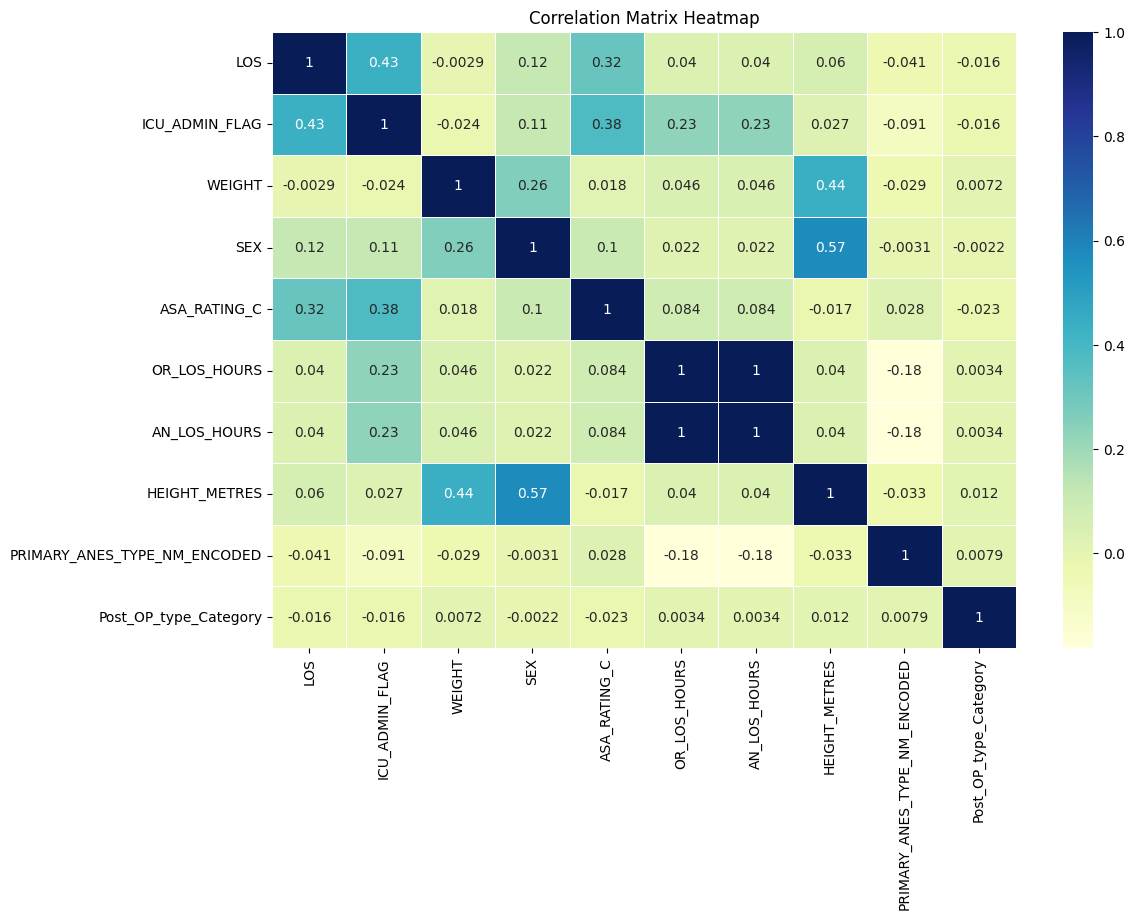

In [31]:
numerical_columns = df_final_label_enc.select_dtypes(include=['float64', 'int64']).columns

df_numerical = df_final_label_enc[numerical_columns]

correlation_matrix = df_numerical.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [32]:
df_final_label_enc['Post_OP_type_Category'].value_counts()

,count
Post_OP_type_Category,
7,58920
8,152
10,106
2,105
1,56
6,23
0,20
3,19
9,15


In [33]:
df_final_label_enc = df_final_label_enc[~((df_final_label_enc['Post_OP_type_Category'] == 7) & df_final_label_enc.isnull().any(axis=1))]

for column in df_final_label_enc.columns:
    if df_final_label_enc[column].isnull().sum() > 0:
        if df_final_label_enc[column].dtype in ['float64', 'int64']:
            skewness = df_final_label_enc[column].skew()
            if abs(skewness) > 1:
                df_final_label_enc[column].fillna(df_final_label_enc[column].median(), inplace=True)
            else:
                df_final_label_enc[column].fillna(df_final_label_enc[column].mean(), inplace=True)

<ipython-input-33-cd51f2d0229c>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final_label_enc[column].fillna(df_final_label_enc[column].mean(), inplace=True)
<ipython-input-33-cd51f2d0229c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_label_enc[column].fillna(df_final_label_enc[column].mean(), inplace=True)
<ipython-input-

In [34]:
balanced_df = pd.DataFrame()
n_sample = 175

for category in df_final_label_enc['Post_OP_type_Category'].unique():
    class_df = df_final_label_enc[df_final_label_enc['Post_OP_type_Category'] == category]

    if len(class_df) > n_sample:
        class_df = resample(class_df, replace=False, n_samples=n_sample, random_state=42)
    elif len(class_df) < n_sample:
        class_df = resample(class_df, replace=True, n_samples=n_sample, random_state=42)

    balanced_df = pd.concat([balanced_df, class_df])


In [35]:
print(f"Class distribution after adjusting to {n_sample} samples each:")
print(balanced_df['Post_OP_type_Category'].value_counts())

Class distribution after adjusting to 175 samples each:
Post_OP_type_Category
7     175
2     175
10    175
8     175
9     175
6     175
3     175
0     175
1     175
4     175
5     175
Name: count, dtype: int64


In [36]:
X = balanced_df[['ICU_ADMIN_FLAG', 'WEIGHT', 'SEX', 'ASA_RATING_C',
                     'OR_LOS_HOURS', 'HEIGHT_METRES','LOS',
                     'PRIMARY_ANES_TYPE_NM_ENCODED']]
Y = balanced_df['Post_OP_type_Category']

In [37]:
encoder = OneHotEncoder(sparse_output=False)
target_encoded = encoder.fit_transform(Y.values.reshape(-1, 1))

In [38]:
label_enc = {7:'Post_OP_type_AN  ADMINISTRATIVE',
 2:'Post_OP_type_AN  AIRWAY',
 10:'Post_OP_type_AN  CARDIOVASCULAR',
 8 : 'Post_OP_type_AN  INJURY/INFECTION',
 9:'Post_OP_type_AN  MEDICATION',
 6 :'Post_OP_type_AN  METABOLIC',
 3:'Post_OP_type_AN  NEUROLOGICAL',
 0:'Post_OP_type_AN AQI',
 1:'Post_OP_type_ANE  OTHER',
 4:'Post_OP_type_ANE  REGIONAL',
 5:'Post_OP_type_ANE  RESPIRATORY'}

In [39]:
class_names = [f"Post_OP_type_{label_enc[i].split()[1]}" for i in label_enc.keys()]
target_encoded_df = pd.DataFrame(target_encoded, columns=class_names)


In [40]:
class_names

['Post_OP_type_ADMINISTRATIVE',
 'Post_OP_type_AIRWAY',
 'Post_OP_type_CARDIOVASCULAR',
 'Post_OP_type_INJURY/INFECTION',
 'Post_OP_type_MEDICATION',
 'Post_OP_type_METABOLIC',
 'Post_OP_type_NEUROLOGICAL',
 'Post_OP_type_AQI',
 'Post_OP_type_OTHER',
 'Post_OP_type_REGIONAL',
 'Post_OP_type_RESPIRATORY']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [42]:
# xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(encoder.categories_[0]), eval_metric='mlogloss', use_label_encoder=False)

In [43]:
# xgb_model.fit(X_train, y_train)

In [44]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': len(np.unique(y_train)),  # No of classes
    'eval_metric': 'mlogloss',  # Logarithmic loss
    'seed': 42
}
evals_result={}
evals = [(dtrain, 'train'), (dtest, 'validation')]
xgb_model = xgb.train(params, dtrain, num_boost_round=124, evals=evals, early_stopping_rounds=18, evals_result=evals_result, verbose_eval=False)


In [45]:
y_pred = xgb_model.predict(dtest)


In [46]:
print(classification_report(y_test, y_pred, target_names=class_names,zero_division=0))

                               precision    recall  f1-score   support

  Post_OP_type_ADMINISTRATIVE       0.97      1.00      0.99        35
          Post_OP_type_AIRWAY       0.90      1.00      0.95        35
  Post_OP_type_CARDIOVASCULAR       0.83      1.00      0.91        35
Post_OP_type_INJURY/INFECTION       0.92      1.00      0.96        35
      Post_OP_type_MEDICATION       1.00      1.00      1.00        35
       Post_OP_type_METABOLIC       0.97      1.00      0.99        35
    Post_OP_type_NEUROLOGICAL       1.00      1.00      1.00        35
             Post_OP_type_AQI       0.59      0.29      0.38        35
           Post_OP_type_OTHER       0.76      0.74      0.75        35
        Post_OP_type_REGIONAL       0.92      1.00      0.96        35
     Post_OP_type_RESPIRATORY       0.91      0.91      0.91        35

                     accuracy                           0.90       385
                    macro avg       0.89      0.90      0.89       385
    

In [47]:
train_loss = evals_result['train']['mlogloss']
val_loss = evals_result['validation']['mlogloss']

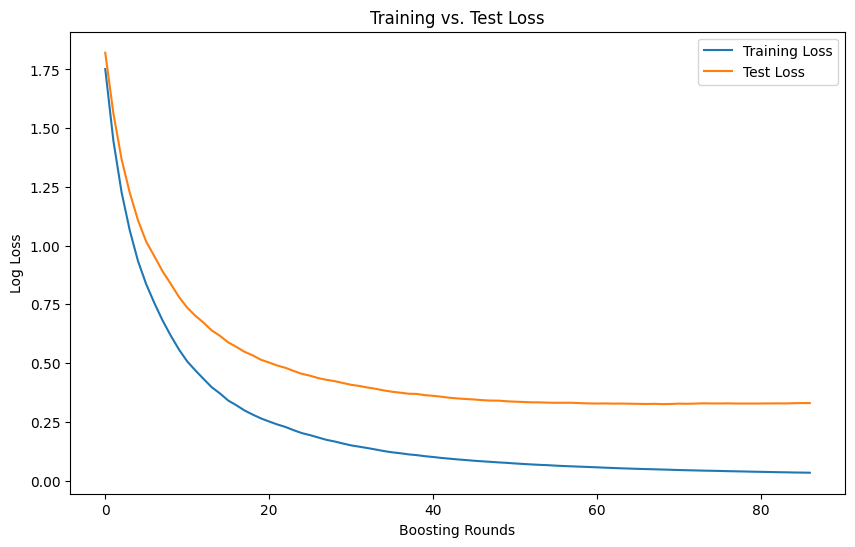

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Training vs. Test Loss')
plt.legend()
plt.show()

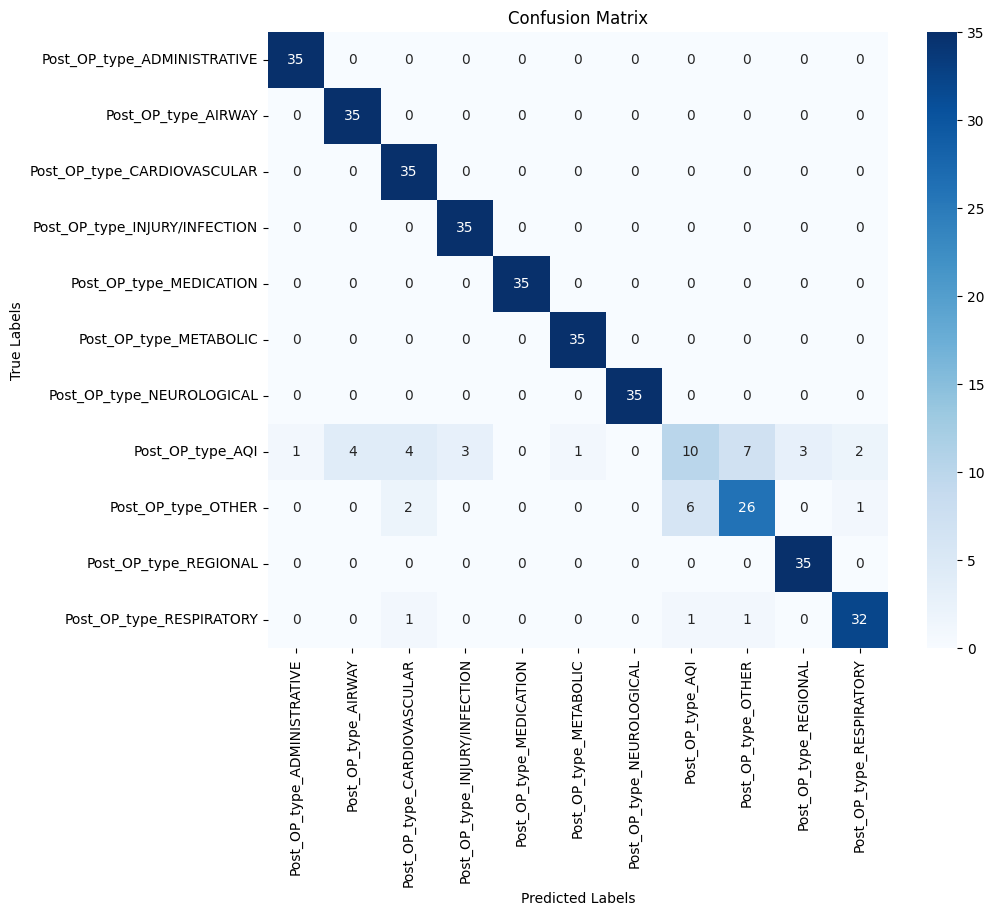

In [49]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [50]:
xgb_classifier = XGBClassifier()
xgb_classifier._Booster = xgb_model
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

y_pred_prob = xgb_model.predict(dtest, output_margin=True)

y_pred_prob = np.exp(y_pred_prob) / np.sum(np.exp(y_pred_prob), axis=1, keepdims=True)

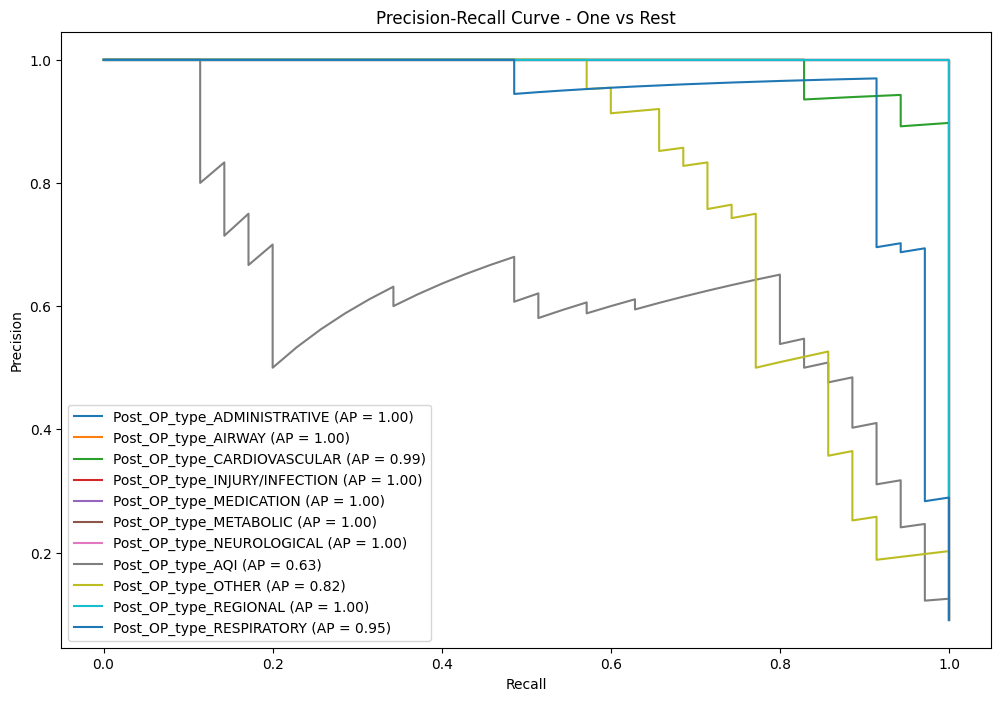

In [51]:
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{class_name} (AP = {ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - One vs Rest')
plt.legend(loc="best")
plt.show()

In [57]:
# Binarize the output for ROC calculations
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))


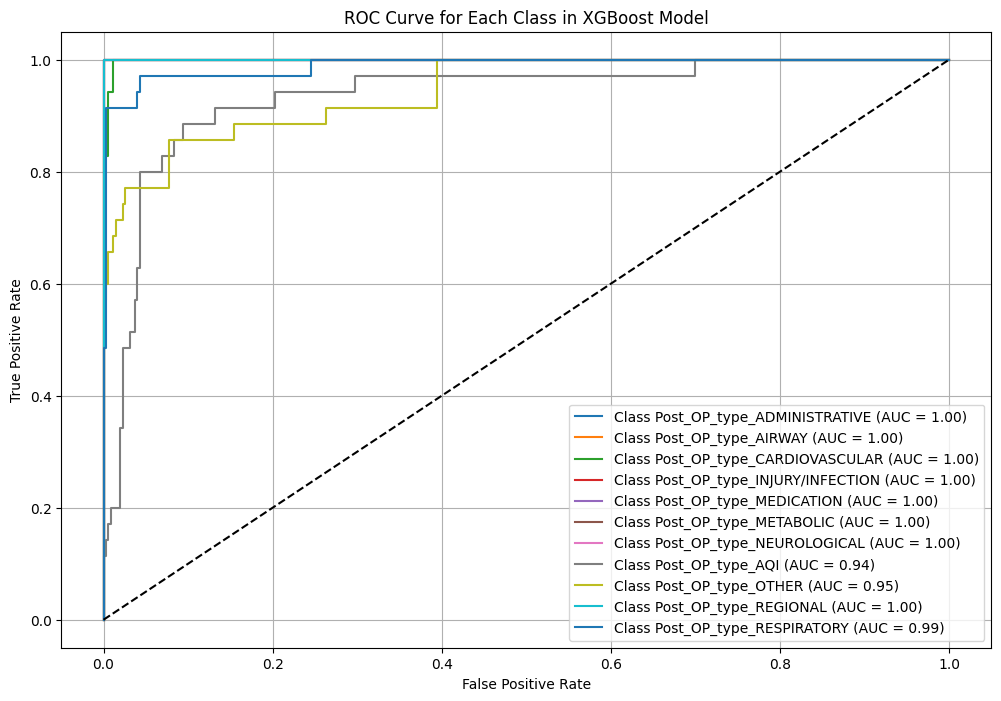

In [59]:
# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

# Plot a diagonal dashed line for reference
plt.plot([0, 1], [0, 1], 'k--')

# Label the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class in XGBoost Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


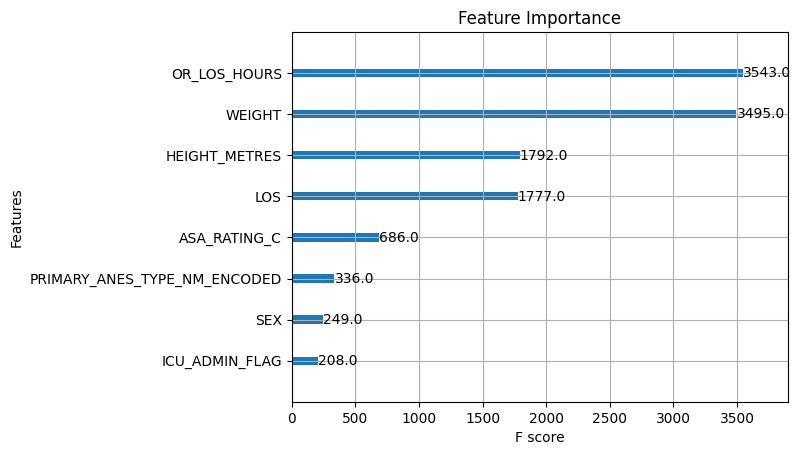

In [60]:
xgb.plot_importance(xgb_model, max_num_features=11)  # Top 11 important features
plt.title("Feature Importance")
plt.show()